## MACHINE TRANSLATION SPANISH-ENGLISH

**Objetivo**

En esta práctica vamos a implementar un traductor español-ingles. Para ello tenemos un corpus con palabras en inglés y su traducción al español. El objetivo es probar diferentes modelos y opciones. 

**¿Qué se ha hecho?**

### Import Required Libraries

In [58]:
import string
import re
from numpy import array, argmax, random, take
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [75]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [76]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [77]:
#Extract files from zip
path_to_zip_file='spa-eng.zip'
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('')

In [78]:
data = read_text("spa-eng\spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [79]:
len(spa_eng)

122936

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [80]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [81]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest.', 'Agradezco tu interés.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [82]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [83]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest', 'Agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [84]:
# convert to lowercase
for i in range(len(spa_eng)):
    deu_eng[i,0] = spa_eng[i,0].lower()
    
    deu_eng[i,1] = spa_eng[i,1].lower()

In [85]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest', 'Agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [86]:
#Remove the third columm
spa_eng=np.delete(spa_eng, 2,axis = 1)

In [87]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda'],
       ['I appreciate your interest', 'Agradezco tu interés']],
      dtype='<U332')

Now we have the correct format for the data

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [88]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [89]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


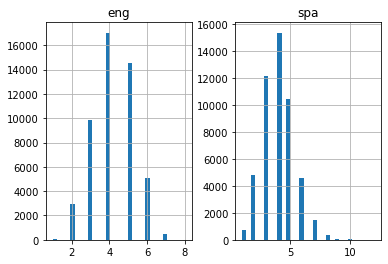

In [90]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 12 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [91]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [92]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [93]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14196


In [94]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 115), ('vete', 30), ('vaya', 41), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 380), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('corrí', 13), ('corría', 4), ('lo', 2116), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5878), ('tomátelo', 2), ('con', 871), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 489), ('mismo', 129), ('id', 6), ('vayan', 11), ('ya', 339), ('¡lo', 10), ('tengo', 876), ('¿lo', 63), ('pillas', 1), ('¿entendiste', 2), ('él', 2559), ('corrió', 23), ('métete', 3), ('adentro', 26), ('abráz

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [95]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building (I)

We will now split the data into train and test set for model training and evaluation, respectively.

In [96]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [97]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [98]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [99]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [100]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [101]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [107]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14196
6942
8
8


In [109]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [110]:
filename = 'model_spa.h1.29_apr_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 185s 6ms/step - loss: 3.9289 - val_loss: 3.3637

Epoch 00001: val_loss improved from inf to 3.36373, saving model to model_spa.h1.29_apr_20
Epoch 2/30
32000/32000 [==============================] - 187s 6ms/step - loss: 3.2408 - val_loss: 3.1948

Epoch 00002: val_loss improved from 3.36373 to 3.19478, saving model to model_spa.h1.29_apr_20
Epoch 3/30
32000/32000 [==============================] - 182s 6ms/step - loss: 3.0726 - val_loss: 3.1476

Epoch 00003: val_loss improved from 3.19478 to 3.14758, saving model to model_spa.h1.29_apr_20
Epoch 4/30
32000/32000 [==============================] - 180s 6ms/step - loss: 2.9412 - val_loss: 2.9868

Epoch 00004: val_loss improved from 3.14758 to 2.98685, saving model to model_spa.h1.29_apr_20
Epoch 5/30
32000/32000 [==============================] - 179s 6ms/step - loss: 2.7890 - val_loss: 2.8367

Epoch 00005: val_loss improved from 2.98

Let's compare the training loss and the validation loss.

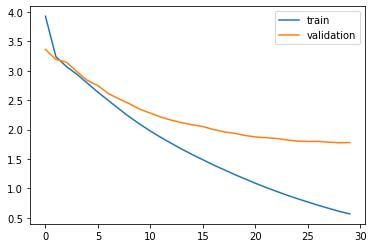

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [112]:
model = load_model('model_spa.h1.29_apr_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [113]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [114]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [115]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [116]:
pd.set_option('display.max_colwidth', 200)

In [117]:
pred_df.head(15)

,actual,predicted
0,They are very cheerful,they are big
1,I know Tom,i know tom
2,You may refuse,you may put
3,Thats private,thats is nonsense
4,Tom leaped from his seat,tom put on his
5,Have you ever sold a car,dont you still a car
6,How many kids do you have,how many do you have
7,I will not let you do it,i never do you do
8,Isnt it beautiful,is it beautiful
9,My parrot died yesterday,my mother died back


In [118]:
pred_df.tail(15)

,actual,predicted
9985,Do Tom and Mary know,did tom know help
9986,Tom can be clumsy,tom might be a
9987,Do you want to try it,do you want to try it
9988,Do you know who he was,do you know who he was
9989,Shes also a beauty,thats a dream
9990,I love your daughter,i want my mommy
9991,He teaches English,he study english cry
9992,I overslept,i was asleep
9993,He is as poor as can be,he is as poor
9994,Wheres my shirt,wheres my husband


In [119]:
pred_df.sample(15)

,actual,predicted
4003,Its so beautiful,thats very beautiful
3643,Are you going anywhere,are you from
5922,Thats nonsense,this is nonsense
17,He wants an iPad,he wants a piece
5470,The food is good,the food is good
7044,Im here by choice,im here in this
8568,He sang some old songs,a demanded an and to
7286,Its hard to surprise Tom,its is easy to
2798,Please dont get angry,please dont be sad
5500,You only live once,ive only married once


Los resultados no son los más adecuados. Nuestro primer traductor no termina de cumplir realmente la función

### Model Building (II)

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model